0. Context

In [4]:
# Purpose
"""
Note:
-> Sequential recommendation models are distinguished by their ability to take into account the order and timing of 
    user interactions with recommended items. Unlike traditional models, which are based primarily on static 
    preferences, sequential models analyse past behaviour to predict future choices, taking into account 
    sequences of actions.

-> These models rely on advanced techniques such as recurrent neural networks (RNNs) and more sophisticated models 
    (transformers), enabling them to capture the complex dynamics of user-item interactions. For example, in the 
    field of e-commerce, a user viewing a product may be influenced by items they have viewed previously, making 
    sequential analysis essential for providing relevant and contextual recommendations.
"""

'\nNote:\n-> Sequential recommendation models are distinguished by their ability to take into account the order and timing of \n    user interactions with recommended items. Unlike traditional models, which are based primarily on static \n    preferences, sequential models analyse past behaviour to predict future choices, taking into account \n    sequences of actions.\n\n-> These models rely on advanced techniques such as recurrent neural networks (RNNs) and more sophisticated models \n    (transformers), enabling them to capture the complex dynamics of user-item interactions. For example, in the \n    field of e-commerce, a user viewing a product may be influenced by items they have viewed previously, making \n    sequential analysis essential for providing relevant and contextual recommendations.\n'

1. Environment configuration

In [ ]:
# 1.1. Load requested libraries
import os
import kagglehub
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.metrics import top_k_categorical_accuracy

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
# 1.2.  Parameters
# * Working directory
HOME = os.getcwd()
HOME = os.path.dirname(HOME)
HOME

# * PARAMETERS
u_path = os.path.join(HOME, 'data', 'raw', 'ml-100k')
adam = Adam(learning_rate=0.0001)

In [7]:
# 1.2. Load dataset
# * Download
path = kagglehub.dataset_download("prajitdatta/movielens-100k-dataset")
print(f"Path to dataset files: {path}")

Path to dataset files: C:\Users\Visiteur\.cache\kagglehub\datasets\prajitdatta\movielens-100k-dataset\versions\1


In [8]:
# * Unzip file
zipfile_path = os.path.join(HOME, 'data', 'raw', 'archive.zip')
destination_path = os.path.join(HOME, 'data', 'raw')

with zipfile.ZipFile(zipfile_path, 'r') as zip_file:
    zip_file.extractall(destination_path)
print("Zip file successfully unzipped")

Zip file successfully unzipped


2. Data preprocessing

2.1. Dataframe definition

In [9]:
# 2.1. Define DataFrame

column_names = ['User', 'Movies', 'rating', 'timestamp']
ratings = pd.read_csv(os.path.join(u_path, 'u.data'), sep='\t', names=column_names) 

# * Load the u.item file (this will be used later to display predicted movies)
u_item_path = os.path.join(u_path, 'u.item')  

# * Define column names for the DataFrame
column_names = [
    'movie_id', 'title', 'release_date', 'video_release_date', 'IMDb_URL',
    'unknown', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy',
    'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
    'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western'
]

# * Read the u.item file into a pandas DataFrame
u_item_df = pd.read_csv(u_item_path, sep='|', header=None, names=column_names, encoding='latin-1')


2.2. Filter dataframe

In [10]:
"""
TO DO
    - Filter the dataframe with positive ratings (scores above 3). Sort the data chronologically (reinitialise 
        the index with reset_index)
    - Calculate the unique number of films rated by each user in the ratings DataFrame, and save it in a 
        DataFrame named user_movie_count.
    - Merge the ratings DataFrame with user_movie_count using the “User” column as the key, keeping only 
        the matching records in both DataFrames.
    - Garder les films qui qui ont été notés au moins 5 fois
    - Extracts unique users from the ratings DataFrame and creates a userid2idx dictionary that associates 
        each user with a numerical index (a Python dictionary can be used). Do the same for movies. 
    - Sequence creation. For each user, create sequences of 6 films viewed chronologically. The sequences of 
        the first 5 films will be stored in a first variable, then the 6th film will be stored in another variable.
"""

'\nTO DO\n    - Filter the dataframe with positive ratings (scores above 3). Sort the data chronologically (reinitialise \n        the index with reset_index)\n    - Calculate the unique number of films rated by each user in the ratings DataFrame, and save it in a \n        DataFrame named user_movie_count.\n    - Merge the ratings DataFrame with user_movie_count using the “User” column as the key, keeping only \n        the matching records in both DataFrames.\n    - Garder les films qui qui ont été notés au moins 5 fois\n    - Extracts unique users from the ratings DataFrame and creates a userid2idx dictionary that associates \n        each user with a numerical index (a Python dictionary can be used). Do the same for movies. \n    - Sequence creation. For each user, create sequences of 6 films viewed chronologically. The sequences of \n        the first 5 films will be stored in a first variable, then the 6th film will be stored in another variable.\n'

In [11]:
# 2.2.1. Filtered data
ratings = ratings[ratings['rating']>3]
ratings = ratings.sort_values(by='timestamp')
ratings.reset_index(inplace=True)
ratings = ratings.drop(['index'],axis=1)
ratings.head()

,User,Movies,rating,timestamp
0,259,255,4,874724710
1,259,286,4,874724727
2,259,298,4,874724754
3,259,185,4,874724781
4,259,173,4,874724843


In [12]:
# 2.2.2. Number of movies rated
user_movie_count = ratings.groupby('User').agg({'Movies':'nunique'}).reset_index()
user_movie_count.head()

,User,Movies
0,1,163
1,2,40
2,3,15
3,4,19
4,5,58


In [13]:
# 2.2.3. Merge dataframes rating with user_movies_count
user_movie_count.columns = ['User', 'User_Movie_count']

merge_ratings_user = ratings.merge(user_movie_count, on="User", how='inner')
merge_ratings_user.head()

,User,Movies,rating,timestamp,User_Movie_count
0,259,255,4,874724710,33
1,259,286,4,874724727,33
2,259,298,4,874724754,33
3,259,185,4,874724781,33
4,259,173,4,874724843,33


In [14]:
# 2.2.4. Keep movies rated at least 5 times
movie_count = merge_ratings_user[merge_ratings_user['User_Movie_count']>5]
movie_count = movie_count.sort_values('timestamp')
movie_count.reset_index(inplace=True)
movie_count = movie_count.drop(['index'],axis=1)
movie_count.head()

,User,Movies,rating,timestamp,User_Movie_count
0,259,255,4,874724710,33
1,259,286,4,874724727,33
2,259,298,4,874724754,33
3,259,185,4,874724781,33
4,259,173,4,874724843,33


In [15]:
# 2.2.5. Extract unique users from ratings 'dataframe'
ratings = movie_count

# * Getting all unique user IDs and all unique movies IDs
users = ratings.User.unique()
movies = ratings.Movies.unique()

# * Create dictionary mapping each user ID to a unique index same for movie ID
userid2idx = {o:i for i,o in enumerate(users)}
moviesid2idx = {o:i for i,o in enumerate(movies)}

# * Reverse dictionary
idx2userid = {i:o for i,o in enumerate(users)}
idx2moviesid = {i:o for i,o in enumerate(movies)}

# Adding new columns
ratings['Movies2'] = ratings.Movies.apply(lambda x: moviesid2idx[x])
ratings['User2'] = ratings.User.apply(lambda x: userid2idx[x])

print(f"DataFrame 'Ratings' description: \n{display(ratings.describe())}\n-----------------------------\n")
print(f"DataFrame 'Ratings' head: \n{display(ratings.head())}")


,User,Movies,rating,timestamp,User_Movie_count,Movies2,User2
count,55341.000000,55341.000000,55341.000000,5.534100e+04,55341.000000,55341.000000,55341.000000
mean,458.344988,377.229035,4.382935,8.834536e+08,109.688206,365.873349,439.858116
std,268.035118,300.338391,0.486107,5.378800e+06,71.814662,318.421741,272.023599
min,1.000000,1.000000,4.000000,8.747247e+08,6.000000,0.000000,0.000000
25%,250.000000,159.000000,4.000000,8.794456e+08,49.000000,131.000000,200.000000
50%,439.000000,286.000000,4.000000,8.825669e+08,100.000000,263.000000,428.000000
75%,680.000000,527.000000,5.000000,8.882052e+08,150.000000,510.000000,672.000000
max,943.000000,1674.000000,5.000000,8.932866e+08,378.000000,1446.000000,933.000000


DataFrame 'Ratings' description: 
None
-----------------------------



,User,Movies,rating,timestamp,User_Movie_count,Movies2,User2
0,259,255,4,874724710,33,0,0
1,259,286,4,874724727,33,1,0
2,259,298,4,874724754,33,2,0
3,259,185,4,874724781,33,3,0
4,259,173,4,874724843,33,4,0


DataFrame 'Ratings' head: 
None


In [16]:
# 2.2.6. Sequence creation
user_list = movie_count['User2'].unique()

x = []
y = []

for i in range(len(user_list)):
    if (i%100 == 0):
        print(i)
    
    # Get all rows for the current user (by numeric user index 'User2')
    total_user_movies = movie_count[movie_count['User2']==user_list[i]].copy()
    # Reset the index to 0..n-1 and drop the old 'index' column
    total_user_movies.reset_index(inplace=True)
    total_user_movies = total_user_movies.drop(['index'],axis=1)
  
    for j in range(total_user_movies.shape[0]-6):
        x.append(total_user_movies.loc[j:(j+4),'Movies2'].tolist())
        y.append(total_user_movies.loc[(j+5),'Movies2'].tolist())


0
100
200
300
400
500
600
700
800
900


In [17]:
# * Convert integer classs labels into one-hot encoded vectors
y = np.asarray(y, dtype=np.int64)  
num_classes = int(np.max(y)) + 1
y2 = tf.one_hot(y, depth=num_classes).numpy()


2.3. Split dataset

In [18]:
# 


x = np.array(x)
trainX, testX, trainY, testY = train_test_split(x, y2, test_size=0.1, random_state=0)

print(
    f"Train X shape: {trainX.shape}\n"
    f"Train Y shape: {trainY.shape}\n"
    f"Test X shape: {testX.shape}\n"
    f"Test Y shape: {testY.shape}\n"
)

Train X shape: (44763, 5)
Train Y shape: (44763, 1447)
Test X shape: (4974, 5)
Test Y shape: (4974, 1447)



In [19]:
display(x[45])
display(trainX[45])

array([246, 243, 806, 398, 757])

array([1320, 1043,  656, 1273, 1132])

3. Modeling

3.1. Model architecture

In [20]:
"""
TO DO
Create a Keras model comprising:
    - an embedding layer with 32 units and an input size equal to the number of possible films to predict.
    - An LSTM layer with 100 units
    - A dense layer with 1000 neurons
    - A dropout layer (0.3) to avoid overfitting
    - Finally, a dense layer with a number of neurons equal to the number of classes to be predicted by the model. Use softmax activation.
"""

'\nTO DO\nCreate a Keras model comprising:\n    - an embedding layer with 32 units and an input size equal to the number of possible films to predict.\n    - An LSTM layer with 100 units\n    - A dense layer with 1000 neurons\n    - A dropout layer (0.3) to avoid overfitting\n    - Finally, a dense layer with a number of neurons equal to the number of classes to be predicted by the model. Use softmax activation.\n'

In [34]:
# * Model hyperparameters preparing
src_vocab = ratings['Movies2'].nunique()    # length of movies vocabulary
n_units = 32                                # Embedding dimension
src_timesteps = 5                           # Length sequence
# tar_vocab = len(set(y))                     # Nb of target class
tar_vocab = y2.shape[1]

In [37]:
# * Model architecture
model = Sequential([
    Embedding(input_dim=src_vocab, output_dim=n_units, input_length=src_timesteps),
    LSTM(100),
    Dense(1000, activation='relu'),
    Dropout(0.3),
    Dense(tar_vocab, activation='softmax')
])

model.summary()


c:\Users\Visiteur\Desktop\Julien\Privacy\13-GitHub Projects\Recommendation Systeme\env_RecommendationSystem\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

3.2. Model training

In [ ]:
"""
TO DO
Compile and train the model (Adam, learning rate = 0.0001, we will monitor accuracy and top_k_categorical_accuracy. 
    We can start with 25 epochs and batch_size=128 depending on the GPUs).
-> (Top-k Accuracy: This metric measures whether the correct film is among the model's top k predictions. For example, if you choose k=5, this means that you are checking whether the recommended film is among the 5 most likely films.)
"""

In [38]:
# * Model compilation
model.compile(
    optimizer=adam,
    loss='categorical_crossentropy',
    metrics=['accuracy', top_k_categorical_accuracy]
)

# * Model training
history = model.fit(trainX, trainY, epochs=25, batch_size=128, validation_data=(testX, testY), verbose = 1)

Epoch 1/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.0073 - loss: 6.8132 - top_k_categorical_accuracy: 0.0305 - val_accuracy: 0.0064 - val_loss: 6.4692 - val_top_k_categorical_accuracy: 0.0328
Epoch 2/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.0074 - loss: 6.4340 - top_k_categorical_accuracy: 0.0319 - val_accuracy: 0.0064 - val_loss: 6.4494 - val_top_k_categorical_accuracy: 0.0308
Epoch 3/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.0076 - loss: 6.4146 - top_k_categorical_accuracy: 0.0317 - val_accuracy: 0.0064 - val_loss: 6.4458 - val_top_k_categorical_accuracy: 0.0294
Epoch 4/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.0072 - loss: 6.4053 - top_k_categorical_accuracy: 0.0325 - val_accuracy: 0.0064 - val_loss: 6.4432 - val_top_k_categorical_accuracy: 0.0328
Epoch 5/25
350/350 ━━━━━━━━━━━━━━━━━━━━ 12s 35ms/step - accuracy: 0.0077 - loss: 6.3961 - top_k_categorical_accuracy: 0.0322 - val_accuracy: 0.0064 - val_loss: 6.4364 -

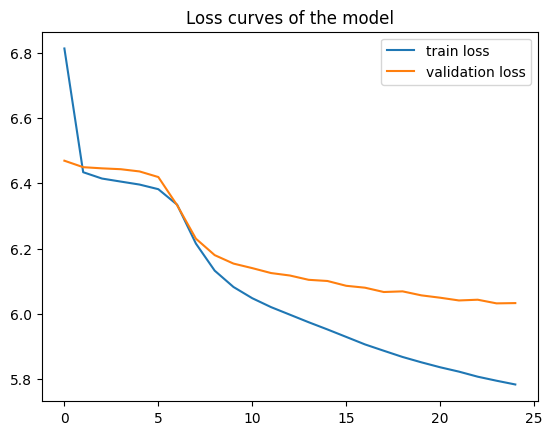

In [40]:
# * Display Loss curves
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="validation loss")
plt.title("Loss curves of the model")

plt.legend(loc="upper right")
plt.show()

3.3. Model evaluating

In [41]:
# * Evaluation on test set
test_loss, test_accuracy,topK = model.evaluate(testX, testY, verbose=1)

print(
    f"Test Loss: {test_loss}\n"
    f"Test Accuracy: {test_accuracy}\n"
    f"TopK 5: {topK}"
)

156/156 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.0131 - loss: 6.0329 - top_k_categorical_accuracy: 0.0599
Test Loss: 6.0329203605651855
Test Accuracy: 0.013067953288555145
TopK 5: 0.059911541640758514


3.4. Model prediction

In [ ]:
# * Predict probability of the sample testX[0]
predictions = model.predict(testX[0].reshape(1, 5))

# * Geting index of class sorted by probabilities in ascending order
sorted_index = np.argsort(predictions[0])[::-1]

# Getting top best 5 class and their probabily
top_k = 5
top_classes = sorted_index[:top_k]
top_probabilities = predictions[0][top_classes]

# * Display results
for i in range(top_k):
    print(f"Classe: {top_classes[i]}| id originel:{idx2moviesid[top_classes[i]]}| nom: {u_item_df[u_item_df['movie_id'] == idx2moviesid[top_classes[i]]]['title'].values[0]}| Probabilité: {top_probabilities[i]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Classe: 224| id originel:98| nom: Silence of the Lambs, The (1991)| Probabilité: 0.006848965771496296
Classe: 137| id originel:204| nom: Back to the Future (1985)| Probabilité: 0.0068287611939013
Classe: 257| id originel:216| nom: When Harry Met Sally... (1989)| Probabilité: 0.006827647797763348
Classe: 67| id originel:196| nom: Dead Poets Society (1989)| Probabilité: 0.006298647727817297
Classe: 30| id originel:79| nom: Fugitive, The (1993)| Probabilité: 0.006297888234257698


4. Display the 5 films from the sequence used as input for the model in the previous step.

In [44]:
# * Display the 5 movies gave by testX[0]
input_movies_index = testX[0]

# * Print result
print("Films provided by testX[0]:")
for i in range(len(input_movies_index)):
    movie_id = idx2moviesid[input_movies_index[i]]  # Get original movie ID
    movie_title = u_item_df[u_item_df['movie_id'] == movie_id]['title'].values[0]  # Get movie title
    print(f"ID: {movie_id}| Nom: {movie_title}")

Films provided by testX[0]:
ID: 204| Nom: Back to the Future (1985)
ID: 613| Nom: My Man Godfrey (1936)
ID: 22| Nom: Braveheart (1995)
ID: 837| Nom: Meet John Doe (1941)
ID: 215| Nom: Field of Dreams (1989)
